### Starter code and helper functions for problem 3

Caleb Fink - Phys 657, Spring 2026


In [4]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, fft, ifft, fftfreq, rfftfreq

Helper functions for doing some of the calculations 

In [5]:
def foldpsd(psd, fs):
    """
    Return the one-sided version of the inputted two-sided psd. Supports an n-dimensional array outputted by `calc_psd`.
    
    Parameters
    ----------
    psd : ndarray
        A two-sided psd to be converted to one-sided
    fs : float
        The sample rate used for the psd

    Returns
    -------
    f : ndarray
        The frequencies corresponding to the outputted one-sided psd
    psd_folded : ndarray
        The one-sided (folded over) psd corresponding to the inputted two-sided psd

    """

    psd_len = psd.shape[-1]
    psd_folded = np.copy(psd[...,:psd_len//2 + 1])
    psd_folded[..., 1:psd_len//2 + (psd_len)%2] *= 2.0
    f = rfftfreq(psd_len, d=1.0/fs)
    
    return f, psd_folded


def calc_psd(x, fs=1.0, folded_over=True):
    """Return the PSD of an n-dimensional array, assuming that we want the PSD of the last axis.
    
    Parameters
    ----------
    x : array_like
        Array to calculate PSD of.
    fs : float, optional
        Sample rate of the data being taken, assumed to be in units of Hz.
    folded_over : bool, optional
        Boolean value specifying whether or not the PSD should be folded over. 
        If True, then the symmetric values of the PSD are multiplied by two, and
        we keep only the positive frequencies. If False, then the entire PSD is 
        saved, including positive and negative frequencies. Default is to fold
        over the PSD.
            
    Returns
    -------
    f : ndarray
        Array of sample frequencies
    psd : ndarray
        Power spectral density of 'x'
        
    """
    
    # calculate normalization for correct units
    norm = fs * x.shape[-1]
    
    if folded_over:
        # if folded_over = True, we calculate the Fourier Transform for only the positive frequencies
        if len(x.shape)==1:
            psd = (np.abs(rfft(x))**2.0)/norm
        else:
            psd = np.mean(np.abs(rfft(x))**2.0, axis=0)/norm
            
        # multiply the necessary frequencies by two (zeroth frequency should be the same, as
        # should the last frequency when x.shape[-1] is odd)
        psd[1:x.shape[-1]//2+1 - (x.shape[-1]+1)%2] *= 2.0
        f = rfftfreq(x.shape[-1], d=1.0/fs)
    else:
        # if folded_over = False, we calculate the Fourier Transform for all frequencies
        if len(x.shape)==1:
            psd = (np.abs(fft(x))**2.0)/norm
        else:
            psd = np.mean(np.abs(fft(x))**2.0, axis=0)/norm
            
        f = fftfreq(x.shape[-1], d=1.0/fs)
    return f, psd

def optimal_filter_amp(signal, template, psd, fs, coupling="AC"):
    """
    Compute the no-delay optimal filter amplitude for a single trace.

    Conventions / assumptions
    -------------------------
    - 'psd' is the full two-sided PSD (length = nbins).
    - FFT normalization follows the convention used in the OptimalFilter class:
        S = fft(template) / nbins / df
        V = fft(signal)   / nbins / df
      where df = fs / nbins.
    - If coupling == "AC" then the zero-frequency bin is ignored (psd[0] set to inf).
    - No time-shifts, no integralnorm, no chi2 / interpolation — just amplitude + sigma.

    Parameters
    ----------
    signal : 1D ndarray
        Time-domain trace (length nbins).
    template : 1D ndarray
        Template pulse (length nbins). Should be aligned/sampled to same grid.
    psd : 1D ndarray
        Two-sided PSD (length nbins). Can contain np.inf at index 0 for AC coupling.
    fs : float
        Sampling rate in Hz.
    coupling : {"AC","DC"}, optional
        If "AC" (default) will set psd[0] = np.inf to ignore DC.

    Returns
    -------
    amp : float
        Optimal filter amplitude (real scalar).
    sigma : float
        Expected 1-sigma amplitude resolution: 1/sqrt(norm).
    """
    signal = np.asarray(signal)
    template = np.asarray(template)
    psd = np.asarray(psd)

    if signal.ndim != 1 or template.ndim != 1 or psd.ndim != 1:
        raise ValueError("signal, template, and psd must be 1D arrays")

    nbins = signal.size
    if not (template.size == nbins == psd.size):
        raise ValueError("signal, template, and psd must have the same length")

    # frequency spacing
    df = fs / nbins

    # make a safe copy of PSD and apply coupling choice
    psd_safe = psd.astype(float).copy()
    if coupling == "AC":
        psd_safe[0] = np.inf

    # avoid division by zero on other bins (tiny floor)
    tiny = np.finfo(float).tiny
    psd_safe = np.where(np.isfinite(psd_safe), np.maximum(psd_safe, tiny), psd_safe)

    # FFT normalization matching the class conventions
    S = fft(template) / nbins / df   # complex
    V = fft(signal)   / nbins / df   # complex

    # frequency-domain filter (phi) and normalization (norm)
    phi = np.conjugate(S) / psd_safe
    norm = np.real(np.dot(phi, S)) * df   # scalar, should be >0 for nonzero template

    if norm <= 0:
        raise RuntimeError("Computed norm is non-positive (check template/psd)")

    # matched numerator
    num = np.sum(phi * V) * df         # complex in general
    amp = np.real(num) / norm          # final amplitude (real)

    # expected 1-sigma energy resolution
    sigma = 1.0 / np.sqrt(norm)

    return amp, sigma

#### Notes about data

* Data are in units of Voltage per time in seconds
* length of events are all 4096 bins long
* the sample rate is 5kHz, which can be used to convert the bins into units of time
* For all pulse data, the pulse will be centered in the middle of the trace

### Load data and inspect a few traces to get a feel for what the data look like

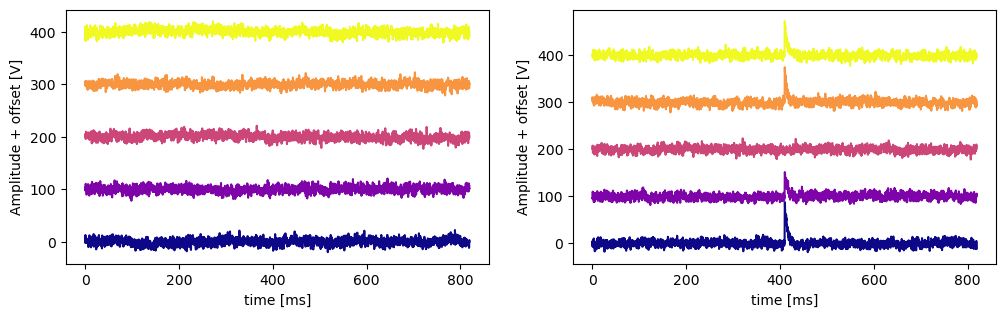

In [27]:
fs = 5e3
trace_length = 4096
dt = 1/fs

noise_data = np.load('/path/to/noise') #should be (300,4096)
pulse_data = np.load('/path/to/pulse_data') #should be (3000,4096)



#make array of event times
time = np.arange(trace_length)*dt #integer spaced data of lenth of traces, multiplied by time between samples


# use calc_psd() to calculate the PSD of the noise. Note, use the 
# flag 'folded_over=False' if you want the full two sided PSD which 
# is what the optimal filter expects. and use 'folded_over=True' if 
# want the one sided PSD for plotting. Also, the two sided PSD can be 
# folded over with the helper function 'foldpsd'

colors = plt.get_cmap("plasma")
c = colors(np.linspace(0,1,5))


fig, ax = plt.subplots(1,2,figsize=(12,3.3))
for ii in range(5):
    ax[0].plot(time*1e3, noise_data[ii]+ii*100, c=c[ii])# artificially adding a y-offset to seperate the data 
    ax[0].set_xlabel('time [ms]')
    ax[0].set_ylabel('Amplitude + offset [V]')
    ax[1].plot(time*1e3, pulse_data[ii]+ii*100, c=c[ii])# artificially adding a y-offset to seperate the data 
    ax[1].set_xlabel('time [ms]')
    ax[1].set_ylabel('Amplitude + offset [V]')
